In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import snowflake.connector as snow
from fuzzywuzzy import fuzz

## Data Prep

In [2]:
# write function to get data from snowflake

def query_snowflake(sql_query):
    '''Runs the supplied query and returns a Pandas dataframe.'''
    
    ctx = snow.connect( 
        account   = os.getenv('snowflake_account'),
        user      = os.getenv('snowflake_username'),
        password  = os.getenv('snowflake_password'),
        warehouse = os.getenv('snowflake_warehouse'),
        role      = os.getenv('snowflake_role')
    )

    cs = ctx.cursor()

    try:
        cs.execute(sql_query)
        data = pd.DataFrame(cs.fetchall())
        data.columns = [x[0] for x in cs.description]
    finally:
        cs.close()

    ctx.close()
    
    return data

In [3]:
# sql query

sql_query = """
    select 
        project_id,
        date_published, 
        proj_state,
        case 
            when (date_start::date >= '2013-01-01') and (date_start::date <= '2030-12-31') 
            then date_start 
            else null 
            end as date_start_remove_errors, 
        coalesce(date_start_remove_errors, dateadd('month', 2, date_published)) as date_start_adj,
        office_id,
        proj_value::float as proj_value
    from bc_prod_db.analytics.fct_projects_published 
    where proj_country in ('US', 'USA')
    and is_copied_project = 0
"""

In [4]:
df = query_snowflake(sql_query)

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.shape

(320038, 7)

In [7]:
# percent nulls 

perc_null = sum(df['proj_value'].isnull())/len(df['proj_value'])
'{:.1%} of project values are null.'.format(perc_null)

'78.2% of project values are null.'

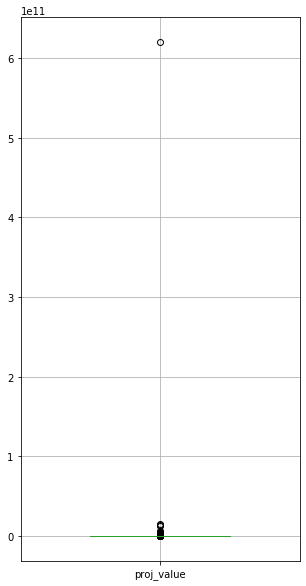

In [8]:
#Visually inspect distribution
df['proj_value']=np.where(df['proj_value'] < 0,np.nan,df['proj_value'])
bp = df[['proj_value']].boxplot(return_type = 'dict', 
                                figsize = (5, 10),
                                widths = (0.5)
)

In [9]:
#Explore inliers 
min_inlier = bp['caps'][0].get_ydata()[0]
print('Min Inlier: ')
display(bp['caps'][0].get_ydata()[0])
max_inlier = bp['caps'][1].get_ydata()[0]
print('Max Inlier: ')
display(bp['caps'][1].get_ydata()[0])

Min Inlier: 


0.0

Max Inlier: 


10420385.0

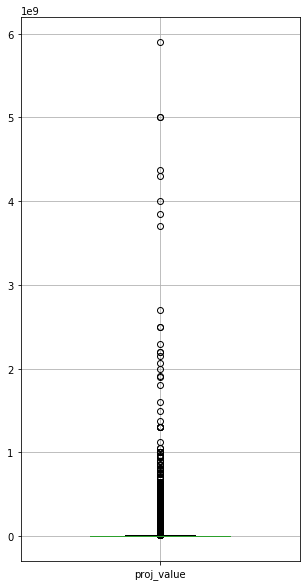

In [10]:
#Inlier range seems to narrow, so manually remove outliers and reinspect distribution
df['date_published']=pd.to_datetime(df['date_published'])
df['date_start_adj']=pd.to_datetime(df['date_start_adj'])
df['proj_value']=np.where(df['proj_value']>= 6000000000,np.nan,df['proj_value'])
df['proj_value']=np.where(df['proj_value']<10,np.nan,df['proj_value'])
bp = df[['proj_value']].boxplot(return_type = 'dict', 
                                figsize = (5, 10),
                                widths = (0.5)
)

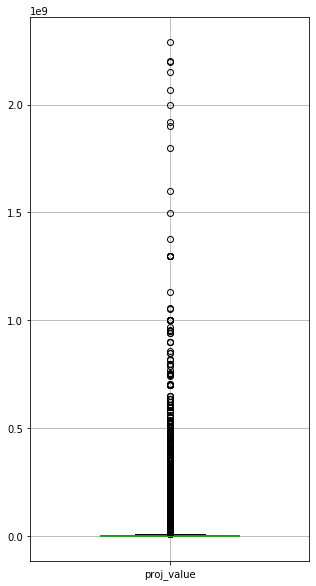

In [11]:
#Long tail still observed, so reduce outlier cutoff
df['proj_value']=np.where(df['proj_value']>= 2500000000,np.nan,df['proj_value'])
bp = df[['proj_value']].boxplot(return_type = 'dict', 
                                figsize = (5, 10),
                                widths = (0.5)
)

In [12]:
print('Mean ($M): ')
display(df['proj_value'].mean()/1000000)
print('Median ($M): ')
display(df['proj_value'].median()/1000000)
mean=df['proj_value'].mean()
median=df['proj_value'].median()

Mean ($M): 


9.436321193236797

Median ($M): 


1.1

## Project Value by State

In [13]:
# Do some proj_state cleanup

def state_fixer(state):
    state_dict = {
        'Arkansas' : 'AR', 
        'Mt' : 'MT',
        'Texas' : 'TX'
    }
    
    if state in state_dict.keys():
        return state_dict[state]
    else:
        return state

df['proj_state'] = df['proj_state'].apply(lambda x: state_fixer(x))

In [14]:
# group mean/median by state

state_values = df.groupby(by = 'proj_state')['proj_value'].agg(['count', 'mean', 'median', 'min', 'max'])
state_values.drop(axis = 0, labels = ['', 'GU'], inplace = True)

In [15]:
state_values['max_formatted'] = state_values['max'].apply(lambda x: '{:,.1f} M'.format(x/1000000))
state_values.sort_values(by = 'max', ascending = False).head(10)

,count,mean,median,min,max,max_formatted
proj_state,,,,,,
CA,10507,1.409733e+07,1700000.0,10.0,2.289841e+09,"2,289.8 M"
GA,2327,8.135541e+06,750000.0,15.0,2.198889e+09,"2,198.9 M"
TX,6581,9.616565e+06,1900000.0,17.0,2.150000e+09,"2,150.0 M"
MI,990,9.496430e+06,802000.0,24.0,2.000000e+09,"2,000.0 M"
WI,389,9.724876e+06,1000000.0,10.0,1.495357e+09,"1,495.4 M"
CO,2923,7.738992e+06,1350444.0,17.0,1.375754e+09,"1,375.8 M"
NY,3642,1.164811e+07,1299500.0,10.0,1.300000e+09,"1,300.0 M"
DC,987,2.588078e+07,1500000.0,37.0,1.130000e+09,"1,130.0 M"
FL,4170,6.888416e+06,800000.0,10.0,1.058404e+09,"1,058.4 M"


In [16]:
# remove projects over 90th percentile for each state

df['rank'] = df.groupby('proj_state')['proj_value'].rank('dense', pct = True, ascending = True)
df_temp = df[df['rank'] <= 0.90]

# now calculate state values again 

state_values = df_temp.groupby(by = 'proj_state')['proj_value'].agg(['count', 'mean', 'median', 'min', 'max'])
# state_values.drop(axis = 0, labels = ['', 'GU'], inplace = True)

In [17]:
state_values['max_formatted'] = state_values['max'].apply(lambda x: '{:,.1f} M'.format(x/1000000))
state_values.sort_values(by = 'max', ascending = False).head(10)

,count,mean,median,min,max,max_formatted
proj_state,,,,,,
DC,878,6.008278e+06,1000000.0,37.0,65000000.0,65.0 M
WA,2161,5.329609e+06,1087180.0,17.0,54000000.0,54.0 M
HI,341,5.550112e+06,2500000.0,25000.0,40000000.0,40.0 M
TN,789,4.421070e+06,1500000.0,44.0,37300000.0,37.3 M
NE,184,4.383678e+06,1000000.0,25000.0,35000000.0,35.0 M
NC,964,5.240591e+06,1500000.0,43.0,33820000.0,33.8 M
WY,87,5.109451e+06,1000000.0,23200.0,33300000.0,33.3 M
NM,235,4.831753e+06,1750000.0,11443.0,30000000.0,30.0 M
ME,119,5.408282e+06,2000000.0,33000.0,30000000.0,30.0 M


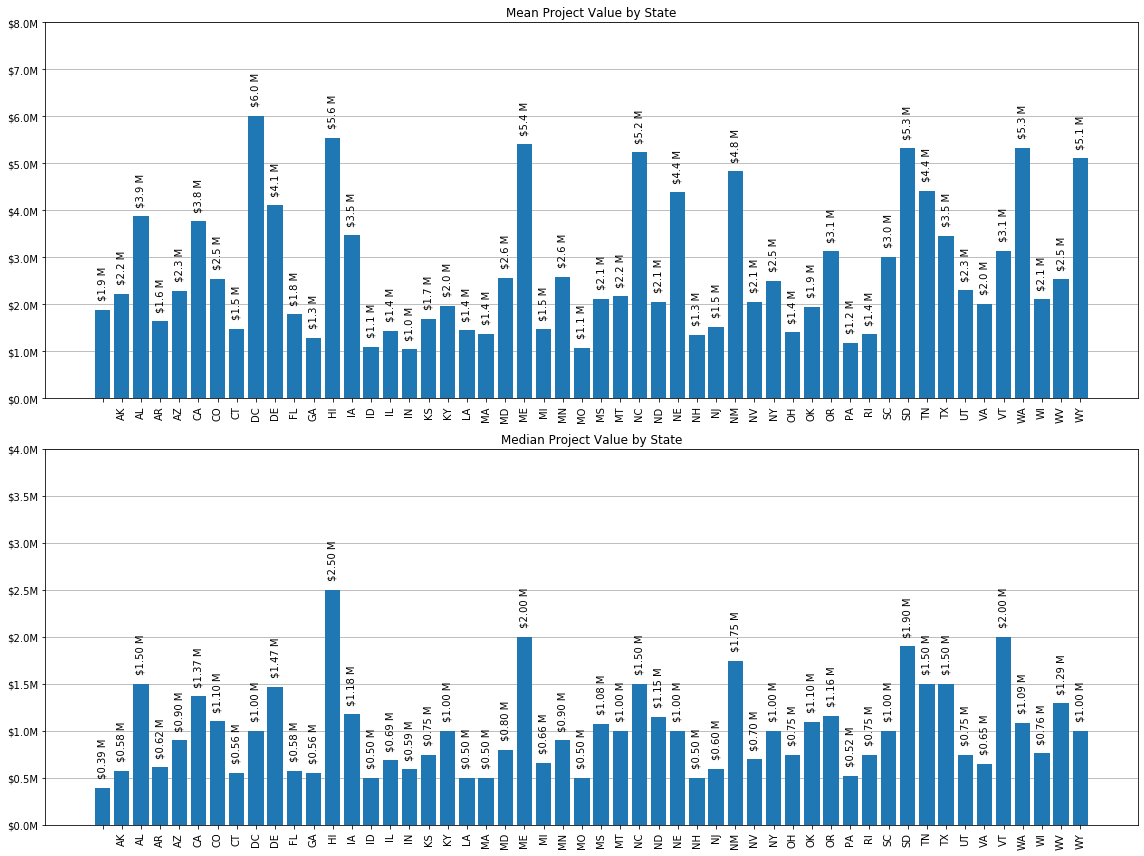

In [120]:
# plot values by state

ind = np.arange(len(state_values))
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 12))

bar1 = ax[0].bar(
    ind, 
    state_values['mean'], 
    zorder = 3
)
bar2 = ax[1].bar(
    ind,
    state_values['median'],
    zorder = 3
)

# format charts 

def millions(x, pos):
    return '$%1.1fM' % (x * 1e-6)

formatter = ticker.FuncFormatter(millions)

for axi in ax:
    axi.set_xticks(ind)
    axi.set_xticklabels(state_values.index, rotation = 90)
    axi.grid(axis = 'y', zorder = 0)
    axi.yaxis.set_major_formatter(formatter)

ax[0].set_title('Mean Project Value by State')
ax[0].set_ylim([0, 8000000])
ax[1].set_title('Median Project Value by State')
ax[1].set_ylim([0, 4000000])

# label values 

xpos = 'center'
ha = {'center': 'center', 'right': 'left', 'left': 'right'}
offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

for rect in bar1:
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width()/2, 
               height + 200000, 
               '${:0,.1f} M'.format(height/1000000), 
               ha = ha[xpos], 
               va = 'bottom', 
               rotation = 90
              )
    
for rect in bar2:
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width()/2, 
               height + 100000, 
               '${:0,.2f} M'.format(height/1000000), 
               ha = ha[xpos], 
               va = 'bottom', 
               rotation = 90
              )

# fix layout

plt.tight_layout()
plt.savefig(fname = 'mean_median_proj_value_by_state.png', 
            dpi = 200);

In [19]:
# gap_filling_method = 'mean'
gap_filling_method = 'median'

In [20]:
if gap_filling_method == 'mean':
    df['proj_value'] = df['proj_value'].fillna(mean)
elif gap_filling_method == 'median': 
    df['proj_value'] = df['proj_value'].fillna(median)

## By Date Published

In [21]:
df_monthly = df.set_index('date_published').resample('M').sum()[['proj_value']]
df_monthly = df_monthly[df_monthly.index >= '2018-01-01']
df_monthly = df_monthly[df_monthly.index < '2020-12-01']

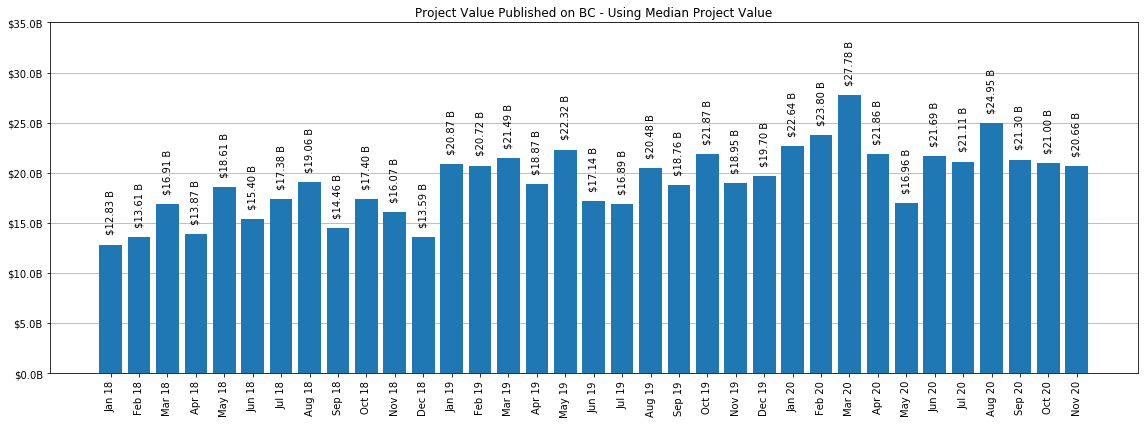

In [22]:
ind = np.arange(len(df_monthly))
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 6))

bar = ax.bar(
    ind, 
    df_monthly['proj_value'], 
    zorder = 3
)

def billions(x, pos): return '$%1.1fB' % (x * 1e-9)
formatter = ticker.FuncFormatter(billions)

ax.set_xticks(ind)
ax.set_xticklabels(df_monthly.index.strftime('%b %y'), rotation = 90)
ax.grid(axis = 'y', zorder = 0)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Project Value Published on BC - Using {} Project Value'.format(gap_filling_method.title()))
ax.set_ylim([0, 35000000000])

for rect in bar:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2, 
        height + 1000000000, 
        '${:0,.2f} B'.format(height/1000000000), 
        ha = ha[xpos], 
        va = 'bottom', 
        rotation = 90
    )
    
plt.tight_layout()
plt.savefig(fname = 'proj_value_published_over_time.png', 
            dpi = 200);

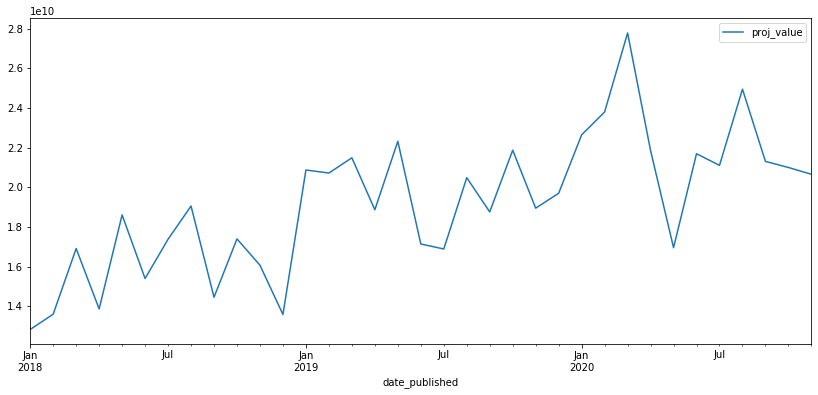

In [23]:
df_monthly.plot(figsize = (14,6));

In [24]:
# df_monthly.to_csv('us_project_value_clean_by_publish_month_median_020720.csv')

In [25]:
df_monthly[df_monthly.index >= '2019-01-01'].head(10)

,proj_value
date_published,
2019-01-31,2.087197e+10
2019-02-28,2.071982e+10
2019-03-31,2.148700e+10
2019-04-30,1.886833e+10
2019-05-31,2.231923e+10
2019-06-30,1.714380e+10
2019-07-31,1.689108e+10
2019-08-31,2.048410e+10
2019-09-30,1.876068e+10


## By Date Start

In [26]:
df_monthly=df.set_index('date_start_adj').resample('M').sum()[['proj_value']]

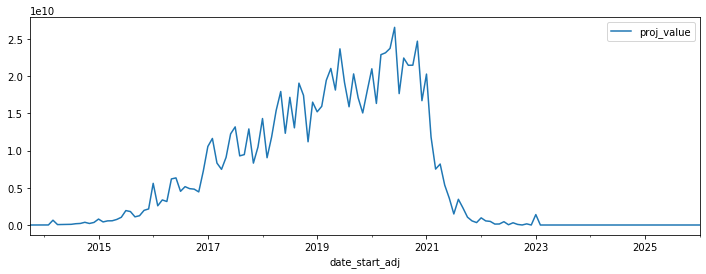

In [27]:
df_monthly.plot(figsize = (12,4));

In [28]:
# df_monthly.to_csv('us_project_value_clean_by_publish_month_median_121019.csv')

In [29]:
df_monthly[df_monthly.index >= '2019-01-01'].head()

,proj_value
date_start_adj,
2019-01-31,1.521611e+10
2019-02-28,1.594846e+10
2019-03-31,1.944551e+10
2019-04-30,2.104106e+10
2019-05-31,1.814205e+10


## Foreign Opps

In [69]:
# foreign_opps_query = '''
#     select 
#         a.unique_id,
#         a.foreign_opportunity_id,
#         a.opportunity_name,
#         a.date_created,
#         a.created_by_id,
#         a.address_complete,
#         a.office_id,
#         b.office_name,
#         b.address_full_address,
#         b.company_id, 
#         b.company_name,
#         coalesce(a.address_state, b.address_state) as state
#     from analytics.dw_bc.fct_bc_foreign_opportunities a
#     left join analytics.dw_bc.fct_bc_office_information b on a.office_id = b.office_id
#     where a.date_created >= '2020-01-01'
#     and b.address_country = 'US'
#     ;
# '''

foreign_opps_query = '''
    select 
        a.unique_id,
        a.foreign_opportunity_id,
        a.opportunity_name,
        a.date_created,
        a.created_by_id,
        a.address_complete,
        a.office_id,
        b.office_name,
        b.address_full_address,
        b.company_id, 
        b.company_name,
        coalesce(a.address_state, b.address_state) as state
    from analytics.dw_bc.fct_bc_foreign_opportunities a
    left join analytics.dw_bc.fct_bc_office_information b on a.office_id = b.office_id
    where b.address_country = 'US'
    ;
'''

In [70]:
df_f = query_snowflake(foreign_opps_query)

In [71]:
df_f.columns = df_f.columns.str.lower()
df_f['date_created'] = df_f['date_created'].dt.tz_localize(None)
df_f.head()

,unique_id,foreign_opportunity_id,opportunity_name,date_created,created_by_id,address_complete,office_id,office_name,address_full_address,company_id,company_name,state
0,96aa15679b5f954db50bc2f2b113f62e,5ce464f08f359400166961ac,Chartwell Midwest Pharmacy Build-Out,2019-05-21 20:52:00.310,5b3aa20a7874f0000fca0863,"1345 Deming Way, Middleton, WI 53562, USA",557a2fbb1862bc08003d0cb8,Madison,"2840 Innovation Way, Sun Prairie, WI 53590, Un...",5430e7a85cdc2e0300dd766d,"Performance Contracting, Inc. (PCI)",WI
1,f2d2c317c7a5948f4c3d28c30e2d2b1a,5ae8aa5ef9652b001091f01f,HP 3L Media - Construction,2018-05-01 17:56:46.168,5476770d3d6c1805002f926b,None,5e8f74be595acb002e9fd843,San Rafael,"713 Estancia Way, San Rafael, CA 94903, USA",5e8f74be595acb002e9fd842,Theo Garcia,CA
2,96836995b25ffb0563a3444764aa3b76,5fa2c9da151a7f0019f343a9,Fort Bend County Emergency Operations Center,2020-11-04 15:33:46.048,5ab182c49d6927000fbc5e3d,"307 Fort St, Richmond, TX 77469, USA",5bc0cf852465f60032294cd0,Houston,"4560 West 34th Street, Suite C, Houston, TX 77...",54c11d75448a73060020ec33,"Cherry Painting Company, Inc.",TX
3,42cd484c2448293cc1d1a1a4060057a7,5ee8ddc311d44e0016d45b20,St. Anthony Hospital - OR Upgrades,2020-06-16 14:57:07.846,5e284c58f85ad1001e2b1f5b,"11600 W 2nd Pl, Lakewood, CO 80228, USA",56686460a5ec2e0a00cef7f4,Denver,"13100 Albrook Dr, Suite 1000, Denver, CO 80239...",5640a9b10cd9950f00e3997c,Commercial Flooring Services,CO
4,3cceb047975c2e4cd84d6888344f6baf,5be068c42ab37000122286ef,COVANCE 3NN Necropsy Remodel,2018-11-05 15:59:00.683,5b3aa20a7874f0000fca0863,"3301 Kinsman Blvd, Madison, WI 53704, USA",557a2fbb1862bc08003d0cb8,Madison,"2840 Innovation Way, Sun Prairie, WI 53590, Un...",5430e7a85cdc2e0300dd766d,"Performance Contracting, Inc. (PCI)",WI


In [72]:
# combine all state names

df_f['state'].fillna('n/a', inplace = True)

def replace_state(state_name):
    
    state_name = state_name.lower().strip() 
    us_state_abbrev = {
        'alabama': 'AL',
        'alaska': 'AK',
        'american samoa': 'AS',
        'arizona': 'AZ',
        'arkansas': 'AR',
        'california': 'CA',
        'colorado': 'CO',
        'connecticut': 'CT',
        'delaware': 'DE',
        'district of columbia': 'DC',
        'florida': 'FL',
        'georgia': 'GA',
        'guam': 'GU',
        'hawaii': 'HI',
        'idaho': 'ID',
        'illinois': 'IL',
        'indiana': 'IN',
        'iowa': 'IA',
        'kansas': 'KS',
        'kentucky': 'KY',
        'louisiana': 'LA',
        'maine': 'ME',
        'maryland': 'MD',
        'massachusetts': 'MA',
        'michigan': 'MI',
        'minnesota': 'MN',
        'mississippi': 'MS',
        'missouri': 'MO',
        'montana': 'MT',
        'nebraska': 'NE',
        'nevada': 'NV',
        'new hampshire': 'NH',
        'new jersey': 'NJ',
        'new mexico': 'NM',
        'new york': 'NY',
        'north carolina': 'NC',
        'north dakota': 'ND',
        'ohio': 'OH',
        'oklahoma': 'OK',
        'oregon': 'OR',
        'pennsylvania': 'PA',
        'puerto rico': 'PR',
        'rhode island': 'RI',
        'south carolina': 'SC',
        'south dakota': 'SD',
        'tennessee': 'TN',
        'texas': 'TX',
        'utah': 'UT',
        'vermont': 'VT',
        'virgin islands': 'VI',
        'virginia': 'VA',
        'washington': 'WA',
        'west virginia': 'WV',
        'wisconsin': 'WI',
        'wyoming': 'WY'
    }
    
    if state_name == '':
        return 'n/a'
    elif state_name in us_state_abbrev:
        return us_state_abbrev[state_name]
    else:
        return state_name

# df_f['original_state'] = df_f['state'].str.lower()
df_f['formatted_state'] = df_f['state'].apply(lambda x: replace_state(x))
df_f['formatted_state'] = df_f['formatted_state'].str.upper()

In [73]:
df_f['formatted_state'].value_counts()

TX               366954
CA               315880
FL               181701
IL               152426
CO               104047
                  ...  
OKLAHOM               1
YIGO                  1
IL.                   1
SAN JUAN              1
WASHINGTON DC         1
Name: formatted_state, Length: 134, dtype: int64

In [74]:
# df_f.groupby(by = 'formatted_state')[['foreign_opportunity_id', 'office_id', 'company_id']].nunique()

In [75]:
relevant_states = ['AL', 'AK', 'AS', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'GU', 'HI', 
                   'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 
                   'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'MP', 'OH', 'OK', 'OR', 'PA', 
                   'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VI', 'VA', 'WA', 'WV', 'WI', 'WY']

df_f2 = df_f[df_f['formatted_state'].apply(lambda x: x in relevant_states)]

In [76]:
state_project_count = pd.DataFrame(df_f2['formatted_state'].value_counts())
state_project_count = state_project_count.reset_index().rename(columns = {'index': 'state', 
                                                                          'formatted_state': 'foreign_opps'})
state_project_count.sort_values(by = 'state', inplace = True)
state_project_count.head()

,state,foreign_opps
50,AK,334
30,AL,13455
36,AR,6583
52,AS,6
10,AZ,70370


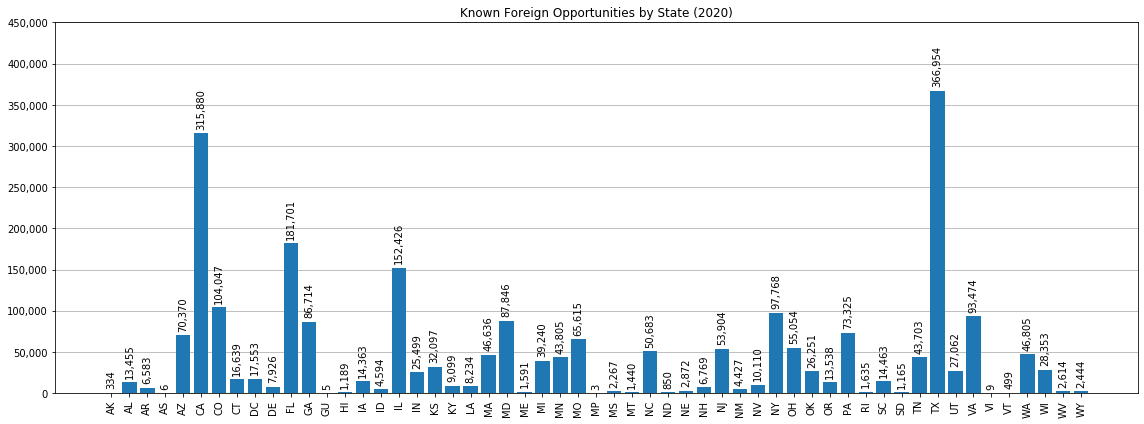

In [123]:
ind = np.arange(len(state_project_count))
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 6))

bar = ax.bar(
    ind, 
    state_project_count['foreign_opps'], 
    zorder = 3
)

ax.set_xticks(ind)
ax.set_xticklabels(state_project_count['state'], rotation = 90)
ax.grid(axis = 'y', zorder = 0)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('Known Foreign Opportunities by State (2020)')
ax.set_ylim([0, 450000])

for rect in bar:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2, 
        height + 5000, 
        '{:0,.0f}'.format(height), 
        ha = ha[xpos], 
        va = 'bottom', 
        rotation = 90
    )
    
plt.tight_layout()
plt.savefig(fname = 'foreign_opps_by_state.png', 
            dpi = 200);

In [78]:
# fuzzy text match

# def fuzzy_text_match(text_to_match, dataframe, column_name):
    
#     for i in dataframe[column_name]:
        

In [79]:
### Look only at select foreign opps

df_temp = df_f2[df_f2['formatted_state'] == 'NY']
df_temp.head()

,unique_id,foreign_opportunity_id,opportunity_name,date_created,created_by_id,address_complete,office_id,office_name,address_full_address,company_id,company_name,state,formatted_state
19,92bb9ba3f0fc4f3877e191fc7c8bc269,5f285813c86077001c255488,Warwick Fire District - New Fire Station,2020-08-03 18:31:47.329,552b53173d418a0a002017d5,"132 S Street Extension, Warwick, NY 10990, USA",552fe26cb16f750800b0d7bd,Concord,"135 Cabarrus Ave E, Concord, NC 28025, USA",54ef5844698ba80800941793,Division 10 Sales,NY,NY
28,a597bfc7620eb194cd48a575325469c6,5dc1710dde68ed001e031b48,"AutoZone #6459 - Saugerties, NY",2019-11-05 12:54:37.345,590cfb1c525ecf0b00d5a3de,"285 Ulster Ave, Saugerties, NY 12477, USA",568bcd232f96060f0003e727,Chicago,"3627 W Harrison St, Chicago, IL 60624, USA",5566072473c7640a000ce1bd,BIOFOAM,NY,NY
64,1f651eca5a3aecce17ca786a71420de5,5f8074092cf405001c496d31,"Family Dollar Dundee, NY",2020-10-09 14:30:33.609,57bc60e7ef88160a000e4695,"1 Water St, Dundee, NY 14837, USA",56ff0080c2d7760f00f91948,Hamilton,"1211 River Rd, Hamilton, NY 13346, USA",56ff0080c2d7760f00f91947,"Ron Wright, Incorporated",NY,NY
75,17deb9de3f7103453b8532e9bfab6f5b,5bd73c22a1c8a200139bf098,NYCHA JEFFERSON HOUSES - COMMUNITY CENTER KITC...,2018-10-29 16:58:10.094,54de1212ad2840060094549a,"New York, NY, USA",56eadb11a6dc300f0053a9fa,Flushing,"65-45 Fresh Meadow Ln, Flushing, NY 11365, USA",54de1212ad28400600945497,Unity International Group,NY,NY
85,da7ae4aea4187bc670db51668a59a0bc,5cc9a7d42520190022d75830,"E7020 Davidson Kempner - 520 Madison, 29-31st ...",2019-05-01 14:06:12.203,54de1212ad2840060094549a,"520 Madison Avenue, 29-31, New York, NY 10022,...",56eadb11a6dc300f0053a9fa,Flushing,"65-45 Fresh Meadow Ln, Flushing, NY 11365, USA",54de1212ad28400600945497,Unity International Group,NY,NY


## Looking at publishing offices from Foreign Opps

In [80]:
domestic_offices = pd.DataFrame(df.groupby('proj_state')['office_id'].nunique())
domestic_offices.rename(columns = {'office_id': 'domestic_offices'}, inplace = True)
domestic_offices.head()

,domestic_offices
proj_state,
,52
AK,37
AL,344
AR,245
AZ,548


In [104]:
foreign_offices = pd.DataFrame(df_f2.groupby('formatted_state')['office_id'].nunique())
foreign_offices.rename(columns = {'office_id': 'foreign_offices'}, inplace = True)
foreign_offices.head()

,foreign_offices
formatted_state,
AK,52
AL,773
AR,736
AS,5
AZ,1482


In [106]:
footprint = pd.merge(
    left = foreign_offices, 
    right = domestic_offices, 
    how = 'left',
    left_index = True,
    right_index = True
)

footprint['footprint'] = footprint['domestic_offices']/footprint['foreign_offices']
footprint.dropna(inplace = True)
footprint

,foreign_offices,domestic_offices,footprint
formatted_state,,,
AK,52,37.0,0.711538
AL,773,344.0,0.445019
AR,736,245.0,0.332880
AZ,1482,548.0,0.369771
CA,5652,1310.0,0.231776
CO,2022,565.0,0.279426
CT,737,254.0,0.344640
DC,541,247.0,0.456562
DE,293,159.0,0.542662


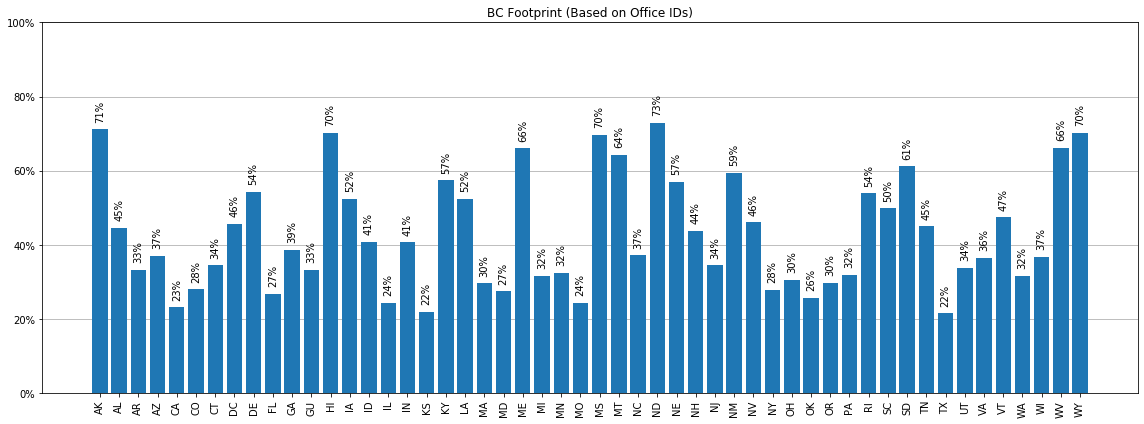

In [117]:
ind = np.arange(len(footprint))
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 6))

bar = ax.bar(
    ind, 
    footprint['footprint'], 
    zorder = 3
)

ax.set_xticks(ind)
ax.set_xticklabels(footprint.index, rotation = 90)
ax.grid(axis = 'y', zorder = 0)
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(x, '.0%')))
ax.set_title('BC Footprint (Based on Office IDs)')
ax.set_ylim([0, 1])

for rect in bar:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width()/2, 
        height + 0.02, 
        '{:.0%}'.format(height), 
        ha = ha[xpos], 
        va = 'bottom', 
        rotation = 90
    )
    
plt.tight_layout()
# plt.savefig(fname = 'foreign_opps_by_state.png', dpi = 200);